In [25]:
# Import packages.
import numpy as np
import matplotlib.pyplot as plt
import qctrlvisualizer
import boulderopal as bo
import qutip as qt
import sys, os
sys.path.append('/Users/sebastien/Documents/Code/QRAM/qutip_sims')
from QSwitch import QSwitch
import time
import scipy as sp
from PulseSequence import PulseSequence
from tqdm import tqdm

import matplotlib as mpl
mpl.style.use('default')
plt.rcParams['figure.figsize'] = [6, 4]

# Apply Q-CTRL style to plots created in pyplot.
# plt.style.use(qctrlvisualizer.get_qctrl_style())

# Start a Boulder Opal session.

%matplotlib widget
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# General definitions

## Define the  parameters

In [26]:

# Pulse parameters
segment_count = 50
gate_duration = 40*1e-9  # s
# check that the gate duration is a multiple of the segment count

dt = np.round(gate_duration*1e9 / segment_count,3)
gate_duration = dt*segment_count*1e-9
print(f'Actual gate duration: {gate_duration} s')



# cutoff_freq = 1e9 # Hz
cutoff_freq = 500e6 # Hz
# Maximum value for |α(t)|.
drive_max = 2*np.pi*50*1e6/10 # rad/s
penalty_coeff = 1e-2
penalty_segments = segment_count
qubit_drive_idx = [0, 1]

twoQ = False

Actual gate duration: 4e-08 s


In [27]:
if twoQ:
    f_ef =  np.array([4140.533743739655, 3463.728373773443])*1e6 # [MHz]
    qubit_freqs = np.array([3914.7570214638718, 3363.398427976613])*1e6
    alphas = (f_ef - qubit_freqs)
    g =  54.38663964*1e6
    gs = np.zeros((2,2))
    gs[0, 1] = g
    gs[1, 0] = g

    # cutoffs= [3, 4]
    cutoffs= [4, 4]

else:
    qubit_freqs = np.array([4140.533743739655, 3463.728373773443, 4800.1199711068375, 4415.307783242773])*1e6
    ef_freqs = np.array([3914.7570214638718, 3363.398427976613, 4610.7977211230145, 4243.1626645869358])*1e6
    alphas = ef_freqs - qubit_freqs

    gs = np.zeros((4,4))
    gs[0, 1] = 54.38663964*1e6
    gs[1, 2] = 52.60236201*1e6
    gs[1, 3] = 41.1249601*1e6
    gs[0, 2] = 6.26475719*1e6
    gs[0, 3] = 2.73059709*1e6
    gs[2, 3] = 6.00700312*1e6

    gs = gs + gs.T


    cutoffs= [3, 3, 3, 3]

# avoided_state = [[3, 4],[3, 4]]
avoided_state = [None,None]




In [28]:
from mpl_toolkits.axes_grid1 import make_axes_locatable
def show_mat_2d(mat, ax, title, labels, cmax=1, show=True):
    """
    Plot an arbitrary 2D matrix with labels
    """
    plt.sca(ax)
    plt.title(title)
    plt.imshow(np.real(mat), cmap='RdBu')
    # hinton(np.real(mat), xlabels=labels, ylabels=labels)
    plt.xticks(np.arange(len(mat)), labels,rotation='vertical',verticalalignment='top')
    plt.yticks(np.arange(len(mat)), labels)
    # Loop over data dimensions and create text annotations.
    for ii in range(len(mat)):
        for jj in range(len(mat)):
            plt.text(ii, jj, round(mat[jj, ii], 2), ha="center", va="center", color="w", size=11)
    divider = make_axes_locatable(ax)
    cax = divider.append_axes("right", size="5%", pad=0.05)
    plt.colorbar(cax=cax)
    plt.clim(vmin=-cmax, vmax=cmax)
    plt.tight_layout()
    if show: plt.show()

def show_plot_rho_2d(rho_test, rho_id=None, title='', cmax=None, savetitle=None, figsize=(15, 15)):
    """
    Plot real and imag parts of rho, optionally also with a comparison ideal rho
    """
    if savetitle is not None: plt.style.use('dark_background')

    cutoffs = rho_test.dims[0]
    print(len(cutoffs))

    if len(cutoffs) == 4:
        labels = [f'$|{qram.level_nums_to_name([i, j, k, l])}\\rangle$' for i in range(2) for j in range(2) for k in range(2) for l in range(2)]
    elif len(cutoffs) == 3:
        labels = [f'$|{qram.level_nums_to_name([i, j, k])}\\rangle$' for i in range(2) for j in range(2) for k in range(2)]
    elif len(cutoffs) == 2:
        labels = [f'$|{qram.level_nums_to_name([i, j])}\\rangle$' for i in range(2) for j in range(2)]
    else:
        labels = [f'$|{qram.level_nums_to_name([i])}\\rangle$' for i in range(2)]
    fig, ax = plt.subplots(2, 1, figsize=figsize)


    plt.suptitle(title, fontsize=18)
    if cmax is None: cmax = np.max(np.abs(np.array([np.real(rho_test), np.imag(rho_test), np.real(rho_id), np.imag(rho_id)])))
    show_mat_2d(np.real(rho_test), ax=ax[0], title="Re[$\\rho_{MLE}$]", labels=labels, cmax=cmax, show=False)
    show_mat_2d(np.imag(rho_test), ax=ax[1], title="Im[$\\rho_{MLE}$]", labels=labels, cmax=cmax, show=False)
    plt.tight_layout()

    if savetitle is not None:
        plt.savefig(savetitle, format='png', bbox_inches='tight', transparent = True)
    
    plt.show()

 ## Define Hamiltonians

In [29]:
isCavity = [False, False, False, False]

qram = QSwitch(
    EJs=None,
    ECs=None,
    gs=gs,
    qubit_freqs=qubit_freqs,
    alphas=alphas,
    cutoffs=cutoffs,
    isCavity=isCavity,
    useZZs=False,
    ZZs=None,
)

print('qubit freqs (GHz)', qram.qubit_freqs/1e9)
print('alphas (GHz)', qram.alphas/1e9)

# define the dressed parameters  
freq_dressed = qram.get_dressed_frequencies()
self_kerr = qram.get_self_kerr()/2/np.pi
ZZ_mat = qram.get_ZZ_matrix()
M = np.diag(qubit_freqs) + gs 
# find the eigenvalues and eigenvectors 
eigenvalues, eigenvectors = np.linalg.eigh(M)
# sort the eigenvalues to match dressed frequency 
idx = np.array([np.argmin(np.abs(eigenvalues  - freq_dressed[k]/2/np.pi)) for k in range(len(freq_dressed))])
eigenvectors = np.abs(eigenvectors[:, idx])


qram_zz_rot = QSwitch(
    EJs=None,
    ECs=None,
    gs=None,
    qubit_freqs=freq_dressed*0,
    alphas=self_kerr,
    cutoffs=cutoffs,
    isCavity=isCavity,
    useZZs=True,
    ZZs=ZZ_mat,
    crosstalk=None,
)

Crosstalk 0 0 1.0
Crosstalk 0 1 0.0
Crosstalk 0 2 0.0
Crosstalk 0 3 0.0
Crosstalk 1 1 1.0
Crosstalk 1 0 0.0
Crosstalk 1 2 0.0
Crosstalk 1 3 0.0
Crosstalk 2 2 1.0
Crosstalk 2 0 0.0
Crosstalk 2 1 0.0
Crosstalk 2 3 0.0
Crosstalk 3 3 1.0
Crosstalk 3 0 0.0
Crosstalk 3 1 0.0
Crosstalk 3 2 0.0
qubit freqs (GHz) [4.14053374 3.46372837 4.80011997 4.41530778]
alphas (GHz) [-0.22577672 -0.10032995 -0.18932225 -0.17214512]
1
One photon transition
1
One photon transition
1
One photon transition
1
One photon transition
1
One photon transition
1
One photon transition
1
One photon transition
1
One photon transition
1
One photon transition
1
One photon transition
1
One photon transition
1
One photon transition
1
One photon transition
1
One photon transition
1
One photon transition
1
One photon transition
1
One photon transition
1
One photon transition
1
One photon transition
1
One photon transition
1
One photon transition
1
One photon transition
1
One photon transition
1
One photon transition
Crosstalk

## Define the state transfert

In [30]:
if twoQ: 
    psi_start = qram_zz_rot.state('gg')
    psi_target = (qram_zz_rot.state('ee') + qram_zz_rot.state('gg') + qram_zz_rot.state('eg') + qram_zz_rot.state('ge')).unit()
else:
    psi_start = qram_zz_rot.state('gggg')
    psi_target = (qram_zz_rot.state('eegg') + qram_zz_rot.state('gggg') + qram_zz_rot.state('eggg') + qram_zz_rot.state('gegg')).unit()

## Define the hamiltonian graph

In [31]:
def graph_hamiltonian(graph, qram, params, **kwargs):
    gate_duration = params['gate_duration']
    H_drift = graph.constant_pwc(constant=qram.H.data.todense(), duration=gate_duration)
    return H_drift

In [32]:
def graph_drive(graph, qram, params):

    nb_qubits = qram.nqubits
    cutoffs = qram.cutoffs
    gate_duration = params['gate_duration']
    segment_count = params['segment_count']
    drive_max = params['drive_max']
    cutoff_freq = params['cutoff_freq']
    driven_qubits = params['driven_qubits']

    envelope_signal = graph.signals.cosine_pulse_pwc(duration=gate_duration, segment_count=segment_count, amplitude=1.0)
    drives = []

    for i in driven_qubits:


        I_raw = graph.real_optimizable_pwc_signal(segment_count=segment_count, duration=gate_duration, maximum=drive_max,minimum=-drive_max, name=f'I_raw_{i}')
        Q_raw = graph.real_optimizable_pwc_signal(segment_count=segment_count, duration=gate_duration, maximum=drive_max, minimum=-drive_max, name=f'Q_raw_{i}')

        I_filtered = graph.filter_and_resample_pwc(
            pwc=I_raw,
            kernel= graph.sinc_convolution_kernel(cutoff_freq),
            segment_count=segment_count,
            name=f"I_filtered_{i}",
        )

        Q_filtered = graph.filter_and_resample_pwc(
            pwc=Q_raw,
            kernel= graph.sinc_convolution_kernel(cutoff_freq),
            segment_count=segment_count,
            name=f"Q_filtered_{i}",
        )

        I = I_filtered * envelope_signal
        Q = Q_filtered * envelope_signal

        I.name = f'I_{i}'
        Q.name = f'Q_{i}'

        drives.append(graph.hermitian_part(graph.pwc_operator(signal=(I - 1j*Q) * 2 * np.pi, operator=qram.a_ops[i].data.todense())))

    # H_drive = graph.pwc_sum(drives)

    return drives

## Define the noise model

In [33]:
# def graph_noise(graph, qram, params): 

#     noise = []
#     gate_duration = params['gate_duration']
#     for i in range(qram.nqubits):
#         a_ops = qram.a_ops[i]
#         n_ops = a_ops.dag()*a_ops
#         n_ops = graph.constant_pwc_operator(operator=n_ops.data.todense(), duration=gate_duration)*1e5
#         noise.append(n_ops)


#     return noise 


def graph_noise(graph, qram, params): 
    noise = []
    gate_duration = params['gate_duration']
    batch = params['batch']
    noise_amp = params['noise_amp']

    for i in range(qram.nqubits):
        a_ops = qram.a_ops[i]
        n_ops = a_ops.dag()*a_ops
        amp = graph.random.normal(shape=(batch, 1), mean=0, standard_deviation=noise_amp)
        n_op = graph.pwc_operator(signal=graph.pwc_signal(values=amp, duration=gate_duration),operator=n_ops.data.todense())
        noise.append(n_op)

    return noise
    

## Define the unitary and projective operators

In [34]:
def subspace_proj(U, qram):

    n_qbs = qram.nqubits
    cutoffs = qram.cutoffs

    state_range = [np.arange(0, 2) for n in range(n_qbs)]
    state_all = np.array(np.meshgrid(*state_range)).T.reshape(-1, len(state_range))

    projected_basis = []
    for state in state_all:
        projected_basis.append(qt.tensor([qt.basis(cutoffs[q], state[q]) for q in range(n_qbs)]))

    computational_projector = np.zeros(shape=(np.prod(cutoffs), np.prod(cutoffs)), dtype=np.complex128)

    for state in projected_basis:
        computational_projector += (state * state.dag()).full()
    
    return computational_projector.conjugate().T @ U @ computational_projector


def subspace_penalty(avoided_state, qram):

    n_qbs = qram.nqubits
    cutoffs = qram.cutoffs

    projected_basis = []
    qubit_states = [None]*n_qbs

    state_range = []
    
    for q in range(n_qbs):
        state_temp = np.arange(cutoffs[q])
        if avoided_state[q] is not None:
            state_temp = np.delete(state_temp, np.array(avoided_state[q]) - 1)
        state_range.append(state_temp)

    state_all = np.array(np.meshgrid(*state_range)).T.reshape(-1, len(state_range))

    for state in state_all:
        projected_basis.append(qt.tensor([qt.basis(cutoffs[q], state[q]) for q in range(n_qbs)]))

    computational_projector_temp = np.zeros(shape=(np.prod(cutoffs), np.prod(cutoffs)), dtype=np.complex128)
    identity = np.eye(np.prod(cutoffs), dtype=np.complex128)

    for state in projected_basis:
        computational_projector_temp += (state * state.dag()).full()

    computational_projector = identity - computational_projector_temp

    return computational_projector

# Define the cost function

## Cost function that account for the avoided level

In [35]:
def cost_function(graph, qram, params): 

    U_target = params['U_target']
    if params['U_penalty'] is not None:
        U_penalty = params['U_penalty']
    else:
        U_penalty = None

    gate_duration = params['gate_duration']
    segment_penalty = params['segment_penalty']
    

    H_drift = graph_hamiltonian(graph, qram, params)
    H_drive = graph_drive(graph, qram, params)
    H_tot = H_drift + H_drive

    sample_times =  np.array([gate_duration])
    unit_op = graph.time_evolution_operators_pwc(hamiltonian=H_tot, sample_times=sample_times, name="unit_eval")
    infidelity_cost = 1 - graph.abs(graph.trace(graph.matmul(U_target.T.conj(), unit_op[-1]))/graph.trace(graph.matmul(U_target.T.conj(), U_target)))


    sample_times_penalty =  np.linspace(0, gate_duration, penalty_segments)
    unit_op_penalty = graph.time_evolution_operators_pwc(hamiltonian=H_tot, sample_times=sample_times_penalty, name="unit_eval_penalty")
    #project the unitary into the subspace of the avoided state
    if U_penalty is not None:
        unit_op_penalty_proj = graph.matmul(U_penalty.conjugate().T, unit_op_penalty) - graph.matmul(unit_op_penalty, U_penalty)
        # take the absolute value of the unitary elements
        unit_op_penalty_proj_abs = graph.abs(unit_op_penalty_proj)
        # sum the absolute values of the unitary elements
        unit_op_penalty_proj_abs_sum = graph.sum(unit_op_penalty_proj_abs)/penalty_segments

        infidelity_cost += penalty_coeff * unit_op_penalty_proj_abs_sum


    infidelity_cost.name = 'infidelity_cost'

    return infidelity_cost





In [36]:
def cost_function_state(graph, qram, params):

    psi_start = params['psi_start']
    psi_target = params['psi_target']
    gate_duration = params['gate_duration']
    # segment_penalty = params['segment_penalty']

    H_drift = graph_hamiltonian(graph, qram, params)
    drive = graph_drive(graph, qram, params)
    H_drive = graph.pwc_sum(drive)
    H_tot = H_drift + H_drive

    evol_state = graph.state_evolution_pwc(initial_state=psi_start.full().flatten(),
                                             hamiltonian=H_tot,
                                             sample_times = np.array([gate_duration]),
                                             krylov_subspace_dimension=30,
                                            name='evol_state')
    

    target_states = psi_target.full().flatten()        
    infidelity = graph.abs(
        graph.sum([1 - 
            graph.abs(graph.sum(
                graph.conjugate(target_states) * evol_state[-1]))**2]),
        name='infidelity'
    )
    
    return infidelity


## Cost function that account for noise

In [37]:
def cost_function_noise(graph, qram, params): 

    U_target = params['U_target']
    gate_duration = params['gate_duration']
    segment_penalty = params['segment_penalty']

    H_drift = graph_hamiltonian(graph, qram, params)
    drive = graph_drive(graph, qram, params)
    H_drive = graph.pwc_sum(drive)
    # noise = graph_noise(graph, qram, params)
    noise = graph_noise(graph, qram, params)
    H_noise = graph.pwc_sum(noise)
    H_tot = H_drift + H_drive + H_noise
    cost = graph.infidelity_pwc(
        hamiltonian=H_tot,
        # noise_operators=noise,
        target=graph.target(U_target),
        name="infidelity_cost",
    )

    return cost

# Run the optimization

In [38]:
# U_penalty = subspace_penalty(avoided_state, qram_zz_rot)
# U_target = subspace_proj(U_ideal,qram_zz_rot)


# batch = 200

output_node_names = []
for i in qubit_drive_idx:
    output_node_names.append(f'I_{i}')
    output_node_names.append(f'Q_{i}')

# params = {
#     'gate_duration': gate_duration,
#     'segment_count': segment_count,
#     'drive_max': drive_max,
#     'cutoff_freq': cutoff_freq,
#     'driven_qubits': qubit_drive_idx,
#     'U_target': U_target,
#     'U_penalty': U_penalty,
#     'segment_penalty': penalty_segments,
#     # 'batch': batch,
#     # 'noise_amp': 5e6,
# }

params_state = {
    'gate_duration': gate_duration,
    'segment_count': segment_count,
    'drive_max': drive_max,
    'cutoff_freq': cutoff_freq,
    'driven_qubits': qubit_drive_idx,
    'psi_start': psi_start,
    'psi_target': psi_target,
}


graph = bo.Graph()
# cost = cost_function(graph, qram_zz_rot, params)
# cost = cost_function_noise(graph, qram_zz_rot, params)

cost = cost_function_state(graph,qram_zz_rot, params_state)

optimization_result = bo.run_optimization(
    graph=graph,
    cost_node_name="infidelity",
    output_node_names=output_node_names,
    cost_history_scope='ALL',
    optimization_count = 5,
    target_cost = 1e-20,)



### ------------------------       Stochastic optimization      ------------------------ ###

# cost_fin = graph.sum(cost) / batch
# cost_fin.name = "cost_stochastic"

# optimization_result = bo.run_stochastic_optimization(
#     graph=graph,
#     cost_node_name="cost_stochastic",
#     output_node_names=output_node_names,
#     cost_history_scope='ALL',
#     iteration_count=500,
#     target_cost = 1e-20,)

# print(f"Optimized infidelity: {optimization_result['cost']:.3e}")

Your task (action_id="1998219") is queued.
Your task (action_id="1998219") has started.
Your task (action_id="1998219") has completed.


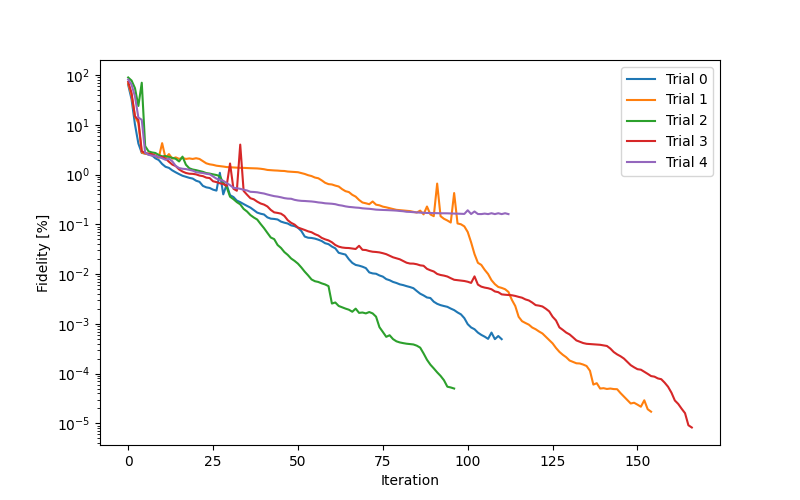

In [39]:
fig, ax = plt.subplots(1, 1, figsize=(8, 5))

for i, opt_res in enumerate(optimization_result['cost_history']['iteration_values']):

    y = 1e2*np.array([opt_res]).flatten()
    ax.plot(y, label=f'Trial {i}')


ax.set_yscale('log')
ax.set_xlabel('Iteration')
ax.set_ylabel('Fidelity [%]')
ax.legend()

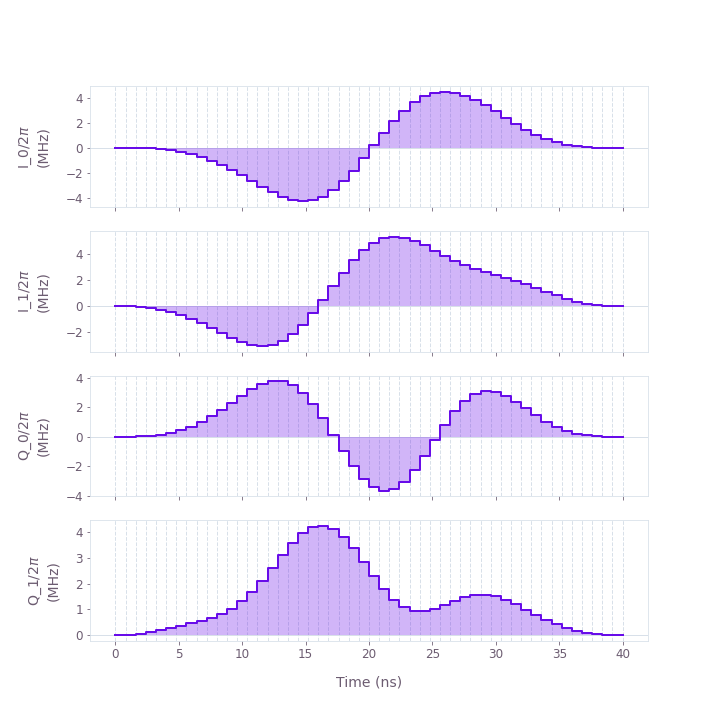

In [40]:
qctrlvisualizer.plot_controls(controls=optimization_result['output'], two_pi_factor=True, polar=False)

In [41]:
output = optimization_result['output']

time_steps = output[output_node_names[0]]['durations']
time_vec = np.cumsum(time_steps)
idx_same = np.where(time_steps < gate_duration/segment_count/10)[0]

I = [output[f'I_{i}']['values'] for i in qubit_drive_idx]
Q = [output[f'Q_{i}']['values'] for i in qubit_drive_idx]

for i in range(len(qubit_drive_idx)):
    I[i] = np.delete(I[i], idx_same)
    Q[i] = np.delete(Q[i], idx_same)

# Plot solver time evoluation

## Qctrl solver

In [42]:
# compute the unitaries for the optimized controls

graph_unitary = bo.Graph()

drive_list = []

for i in range(len(qubit_drive_idx)):
    drive = I[i] - 1j*Q[i]
    drive_opt = graph_unitary.hermitian_part(graph_unitary.pwc_operator(signal=graph_unitary.pwc_signal(values=drive*2*np.pi, duration=gate_duration), operator=qram_zz_rot.a_ops[qubit_drive_idx[i]].data.todense()))
    drive_list.append(drive_opt)

drive_opt = graph_unitary.pwc_sum(drive_list)

H_drift_opt = graph_unitary.pwc_operator(
    signal=graph_unitary.pwc_signal(values=np.array([1]), duration=gate_duration),
    operator=qram_zz_rot.H.data.todense(),
)

H_tot_opt = graph_unitary.pwc_sum([H_drift_opt, drive_opt])
sample_times = np.linspace(0, gate_duration, segment_count)
unitaries = graph_unitary.time_evolution_operators_pwc(
    hamiltonian=H_tot_opt, sample_times=sample_times, name="unitaries"
)

In [43]:
result = bo.execute_graph(graph=graph_unitary, output_node_names=["unitaries"])

Your task (action_id="1998220") has started.
Your task (action_id="1998220") has completed.


In [44]:
# U_opt = qt.Qobj(result['output']['unitaries']['value'][-1])
# U_target = qt.Qobj(U_target)

dims = []

for i in range(qram_zz_rot.nqubits):
    dims.append(cutoffs[i])



# U_target.dims = [dims, dims]
# U_opt.dims = [dims, dims]

# # Infidelities = (1 - ((U_target.dag()*U_opt).tr()/(U_target.dag()*U_target).tr())**2).real
# Infidelities = 1 - np.abs((U_target.dag()*U_opt).tr())/np.abs((U_target.dag()*U_target).tr())

# print('Infidelity %.3f'%(Infidelities*100) + '%')

In [45]:
# qubit_excited = 0 
# psi_idx_ground = [0]*qram_zz_rot.nqubits
# psi_idx_excited = [0]*qram_zz_rot.nqubits
# psi_idx_excited[qubit_excited] = 1
# psig = qram_zz_rot.state(qram_zz_rot.level_nums_to_name(psi_idx_ground))
# psie = qram_zz_rot.state(qram_zz_rot.level_nums_to_name(psi_idx_excited))
# psi0 = (psig + psie).unit()
# psi_ideal = U_ideal*psi0

psi0 = psi_start

Text(0, 0.5, 'Population')

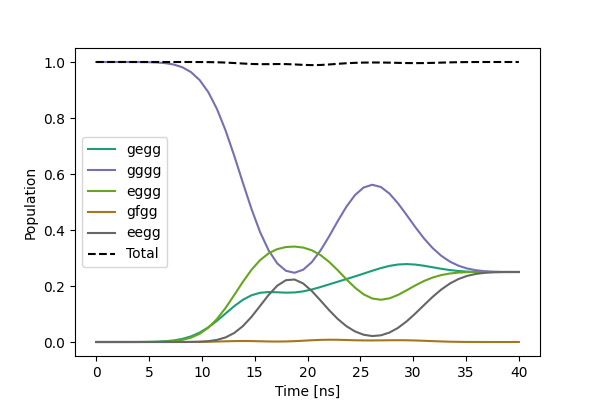

In [46]:
psi_time = result['output']["unitaries"]["value"] @ (psi0.full())
sample_times = np.linspace(0, gate_duration, segment_count)

psi_plot = []
cutoff_range = [np.arange(0, c) for c in qram_zz_rot.cutoffs]
cutoff_all  = np.array(np.meshgrid(*cutoff_range)).T.reshape(-1, len(cutoff_range))

for t in [0, len(psi_time)//3, 2*len(psi_time)//3,-1]:
    for c in cutoff_all:
        psi_idx = qram_zz_rot.level_nums_to_name(c)
        psi = qram_zz_rot.state(psi_idx)
        ov = np.abs(psi.overlap(qt.Qobj(psi_time[t])))
        if ov > 0.05:
            psi_plot.append(psi_idx)

psi_plot = list(set(psi_plot))

cmap = plt.get_cmap('Dark2')
colors = cmap(np.linspace(0, 1, len(psi_plot)))
figs, axs = plt.subplots(1, 1)


prob_sum = np.zeros(len(psi_time))

for psi in psi_plot:
    state = qram_zz_rot.state(psi)
    prob = [np.abs(state.overlap(qt.Qobj(psi_time[t])))**2 for t in range(len(psi_time))]
    prob_sum += prob

for psi in psi_plot: 
    state = qram_zz_rot.state(psi)

    # prob = [np.abs(state.dag()*result_rot[t]*state.full()).flatten() for t in range(len(times))]
    prob = [np.abs(state.overlap(qt.Qobj(psi_time[t])))**2 for t in range(len(psi_time))]

    axs.plot(sample_times*1e9, prob, label=psi, color=colors[psi_plot.index(psi)], )
axs.plot(sample_times*1e9, prob_sum, label='Total', color='black', linestyle='--')

axs.legend()
axs.set_xlabel('Time [ns]')
axs.set_ylabel('Population')


In [47]:
U_list = []
for p in range(qram_zz_rot.nqubits):
    U_temp =np.zeros((cutoffs[p], cutoffs[p]))
    U_temp[:2, :2] = qt.qeye(2).full()
    U_temp = qt.Qobj(U_temp)
    U_list.append(U_temp)
U = qt.tensor(U_list).full()
zeros = np.argwhere(np.diag(U) != 0).flatten()

 /var/folders/ly/kn2rqx_n00d94y4104blzhxm0000gn/T/ipykernel_53062/4163169768.py: 4

In [48]:
# project the final state in the qubit subspace
psi_time_qb = psi_time[-1][zeros]
psi_time_qb = qt.Qobj(psi_time_qb)
psi_time_qb.dims = [dims, dims]


4


 /var/folders/ly/kn2rqx_n00d94y4104blzhxm0000gn/T/ipykernel_53062/3308495072.py: 20UserWarning: The figure layout has changed to tight
 /var/folders/ly/kn2rqx_n00d94y4104blzhxm0000gn/T/ipykernel_53062/3308495072.py: 47

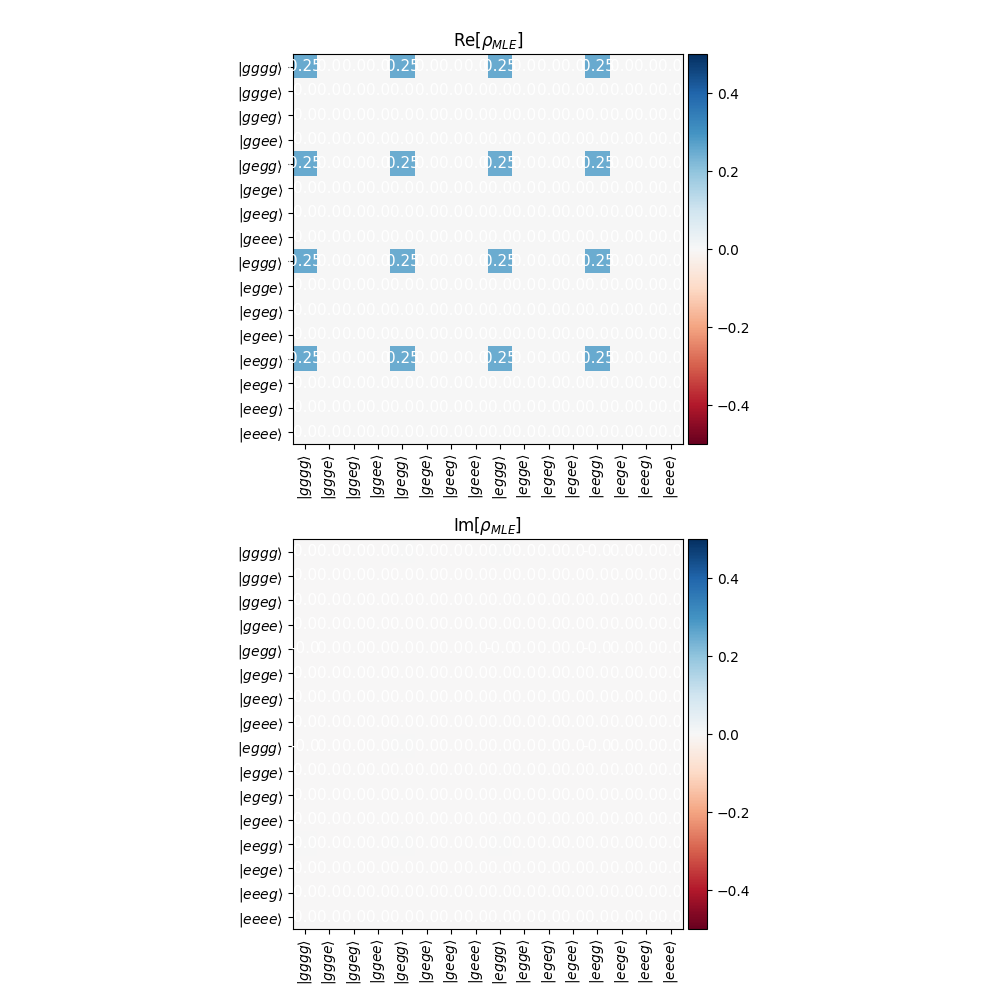

In [56]:
# plot the density matrix of the final state
rho_plot = psi_time_qb*psi_time_qb.dag()
show_plot_rho_2d(rho_plot, cmax=0.5, figsize=(10, 10))

## Qswitch solver

In [50]:
seq = PulseSequence(start_time=0)
nb_point_sim = 1000
time = np.linspace(0, gate_duration, segment_count)

levels = 'g'*qram_zz_rot.nqubits

for d in range(len(qubit_drive_idx)):
    if d == 0: 
        seq.pulse_IQ(amp=1, wd=freq_dressed[qubit_drive_idx[d]], I_values=I[d], Q_values=Q[d], pulse_levels=(levels,levels),  times=time, drive_qubit=qubit_drive_idx[d], t_start=0, phase=0)
    else:
        seq.pulse_IQ(amp=1, wd=freq_dressed[qubit_drive_idx[d]], I_values=I[d], Q_values=Q[d], pulse_levels=(levels,levels),  times=time, drive_qubit=qubit_drive_idx[d], t_start=0, phase=0, t_offset=-gate_duration)

times = np.linspace(0, seq.get_pulse_lengths()[-1], nb_point_sim)

[4144585866.376249, 3455665788.7229967] (GHz)
[4.e-08 4.e-08] (ns)
total pulse length 8e-08 ns


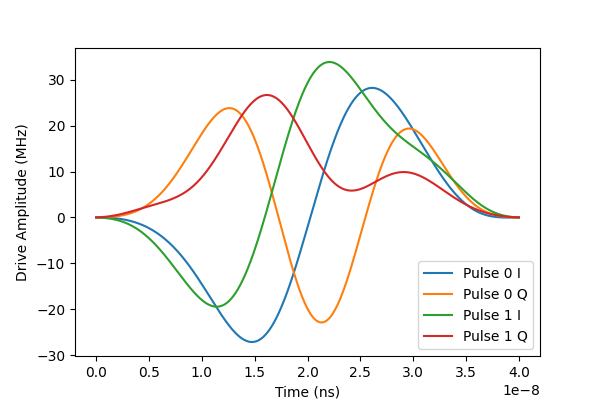

In [51]:
envelope_seq = seq.get_envelope_seq()
pulse_amps = seq.get_pulse_amps()
pulse_freqs = seq.get_pulse_freqs()
pulse_lens = seq.get_pulse_lengths()
drive_funcs = seq.get_pulse_seq()
print(seq.get_pulse_freqs(), '(GHz)')
print(pulse_lens, '(ns)')
print('total pulse length', sum(seq.get_pulse_lengths()), 'ns')


flat_times = np.array(times).flatten()
envelope_v_times = []






fig, ax = plt.subplots(1, 1)

for i in range(len(envelope_seq)):
    if isinstance(envelope_seq[i], list) and len(envelope_seq[i]) == 2:
        envelope_v_time_I = [pulse_amps[i]*envelope_seq[i][0](t)*1e-6 for t in flat_times]
        envelope_v_time_Q = [pulse_amps[i]*envelope_seq[i][1](t)*1e-6 for t in flat_times]
        ax.plot(flat_times, envelope_v_time_I, label=f'Pulse {i} I')
        ax.plot(flat_times, envelope_v_time_Q, label=f'Pulse {i} Q')
        # ax.plot(time, drive_output_i/1e6, label=f'Pulse {i} I opt')
        # ax.plot(time, drive_output_q/1e6, label=f'Pulse {i} Q opt')
    else:
        envelope_v_time = [pulse_amps[i]*envelope_seq[i](t)*1e3 for t in flat_times]
        envelope_v_times.append(envelope_v_time)
        plt.plot(flat_times, envelope_v_time, label=f'Pulse {i}')
ax.set_xlabel('Time (ns)')
ax.set_ylabel('Drive Amplitude (MHz)')
# plt.xlim(0, 100)
ax.legend()

In [52]:
# psig = qram.state(qram.level_nums_to_name(psi_idx_ground))
# psie = qram.state(qram.level_nums_to_name(psi_idx_excited))
# psi0 = (psig + psie).unit()

if twoQ:
    psi0 = qram.state('gg')
else:
    psi0 = qram.state('gggg')
result_lab = qram.evolve(psi0, seq, times, c_ops=None, nsteps=2000, use_str_solve=False)

10.0%. Run time:   0.13s. Est. time left: 00:00:00:01
20.0%. Run time:   0.36s. Est. time left: 00:00:00:01
30.0%. Run time:   0.64s. Est. time left: 00:00:00:01
40.0%. Run time:   0.94s. Est. time left: 00:00:00:01
50.0%. Run time:   1.25s. Est. time left: 00:00:00:01
60.0%. Run time:   1.57s. Est. time left: 00:00:00:01
70.0%. Run time:   1.93s. Est. time left: 00:00:00:00
80.0%. Run time:   2.28s. Est. time left: 00:00:00:00
90.0%. Run time:   2.60s. Est. time left: 00:00:00:00
Total run time:   2.92s


In [53]:
evals, evecs = qram.H_rot_unrolled().eigenstates()
result_rot = [0*result_lab[i_t] for i_t in range(len(times))]

# result_rot = result_lab

for i_t, t in enumerate(tqdm(times)):
    for eval, evec in zip(evals, evecs):
        result_rot[i_t] += np.exp(1j*eval*t) * evec.overlap(result_lab[i_t]) * evec

100%|██████████| 1000/1000 [00:08<00:00, 116.83it/s]


Text(0, 0.5, 'Population')

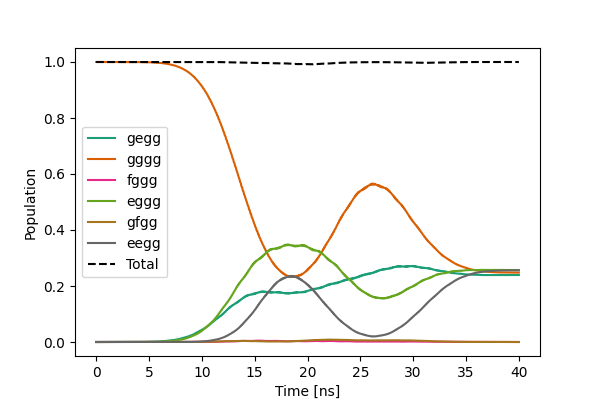

In [54]:
psi_time = result_rot
psi_plot = []
cutoff_range = [np.arange(0, c) for c in qram.cutoffs]
cutoff_all  = np.array(np.meshgrid(*cutoff_range)).T.reshape(-1, len(cutoff_range))

for t in [0, len(psi_time)//3, 2*len(psi_time)//3,-1]:
    for c in cutoff_all:
        psi_idx = qram.level_nums_to_name(c)
        psi = qram.state(psi_idx)
        ov = np.abs(psi.overlap(psi_time[t]))
        if ov > 0.05:
            psi_plot.append(psi_idx)

psi_plot = list(set(psi_plot))

cmap = plt.get_cmap('Dark2')
colors = cmap(np.linspace(0, 1, len(psi_plot)))
figs, axs = plt.subplots(1, 1)
prob_sum = np.zeros(len(psi_time))

for psi in psi_plot:
    state = qram.state(psi)
    prob = [np.abs(state.overlap(psi_time[t]))**2 for t in range(len(psi_time))]
    prob_sum += prob

for psi in psi_plot: 
    state = qram.state(psi)

    # prob = [np.abs(state.dag()*result_rot[t]*state.full()).flatten() for t in range(len(times))]
    prob = [np.abs(state.overlap(psi_time[t]))**2 for t in range(len(psi_time))]

    axs.plot(times*1e9, prob, label=psi, color=colors[psi_plot.index(psi)])
axs.plot(times*1e9, prob_sum, label='Total', color='black', linestyle='--')

axs.legend()
axs.set_xlabel('Time [ns]')
axs.set_ylabel('Population')



4


 /var/folders/ly/kn2rqx_n00d94y4104blzhxm0000gn/T/ipykernel_53062/3308495072.py: 20UserWarning: The figure layout has changed to tight
 /var/folders/ly/kn2rqx_n00d94y4104blzhxm0000gn/T/ipykernel_53062/3308495072.py: 47

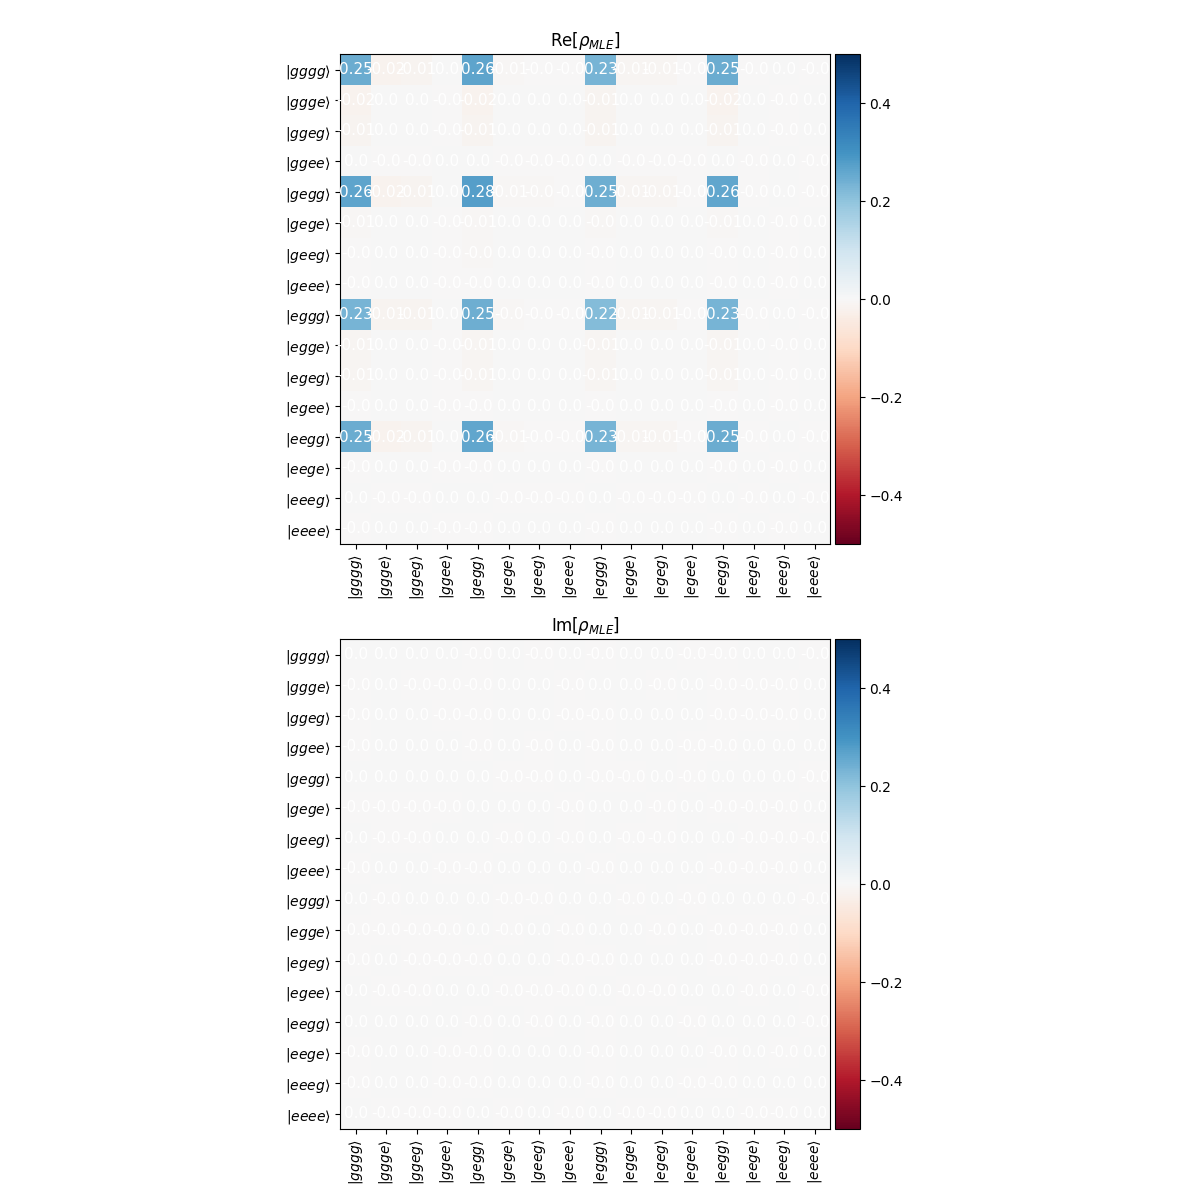

In [58]:
# project the final state in the qubit subspace
psi_plot = result_rot[-1].full()[zeros]
psi_plot = qt.Qobj(psi_plot)
psi_plot.dims = [dims, dims]

# plot the density matrix of the final state

rho_plot = psi_plot*psi_plot.dag()

show_plot_rho_2d(rho_plot, cmax=0.5, figsize=(12, 12))

In [61]:
# compute the fidelity between the two states

fidelity = qt.metrics.fidelity(psi_target, result_rot[-1])

print('Fidelity %.3f'%(fidelity*100) + '%')

Fidelity 99.340%
